In [47]:
import os
from collections import defaultdict
import glob
import random
import torch
import torch.nn as nn
import numpy as np
import tensorflow as tf
from torch.utils.data import Dataset, DataLoader
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, LSTM, Dense, Bidirectional, Input, Dropout, Attention, add, Add
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.optimizers import Adam
from keras.preprocessing.image import load_img, img_to_array
from keras.utils import to_categorical, plot_model
from keras.models import Model, load_model
from tqdm.notebook import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from itertools import chain

In [3]:
# Count data
flickr8k_data = glob.glob('/content/flickr8k/Images/*.jpg')
print(f"count of Flickr8k images :  {len(flickr8k_data)}")

count of Flickr8k images :  8091


In [4]:
# Use GPU
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Use {DEVICE} device")

Use cuda device


In [5]:
# Create a dictionary that has image name as key and all 5 captions as value
def read_image_captions(filename):
    image_descriptions = defaultdict(list)
    with open(filename,'r') as file_list:
        next(file_list)
        for line in file_list:
            line = line.strip()
            img_caption_list = line.split(".jpg,")
            img_name, captions = img_caption_list[0] + ".jpg", img_caption_list[1]
            caption_list = ["<START>"] + captions.lower().split(" ") + ["<END>"]
            image_descriptions[img_name].append(caption_list)
    return image_descriptions

In [6]:
dataset = read_image_captions("/content/flickr8k/captions.txt")

In [7]:
print(dataset["1001773457_577c3a7d70.jpg"])

[['<START>', 'a', 'black', 'dog', 'and', 'a', 'spotted', 'dog', 'are', 'fighting', '<END>'], ['<START>', 'a', 'black', 'dog', 'and', 'a', 'tri-colored', 'dog', 'playing', 'with', 'each', 'other', 'on', 'the', 'road', '.', '<END>'], ['<START>', 'a', 'black', 'dog', 'and', 'a', 'white', 'dog', 'with', 'brown', 'spots', 'are', 'staring', 'at', 'each', 'other', 'in', 'the', 'street', '.', '<END>'], ['<START>', 'two', 'dogs', 'of', 'different', 'breeds', 'looking', 'at', 'each', 'other', 'on', 'the', 'road', '.', '<END>'], ['<START>', 'two', 'dogs', 'on', 'pavement', 'moving', 'toward', 'each', 'other', '.', '<END>']]


In [8]:
for key in dataset:
    dataset[key] = [' '.join(word_list) for word_list in dataset[key]]

# Now print an entry to see if it's what you expected
print(dataset["1001773457_577c3a7d70.jpg"])

['<START> a black dog and a spotted dog are fighting <END>', '<START> a black dog and a tri-colored dog playing with each other on the road . <END>', '<START> a black dog and a white dog with brown spots are staring at each other in the street . <END>', '<START> two dogs of different breeds looking at each other on the road . <END>', '<START> two dogs on pavement moving toward each other . <END>']


In [9]:
flatten_list = list(chain.from_iterable(dataset.values()))

tokenizer = Tokenizer(oov_token='<oov>')
tokenizer.fit_on_texts(flatten_list)
total_words = len(tokenizer.word_index) + 1

print("Vocabulary length: ", total_words)

Vocabulary length:  8495


In [10]:
text_processor = Tokenizer(oov_token='<unknown>')
flat_list = [item for sublist in dataset.values() for item in sublist]
text_processor.fit_on_texts(flat_list)
total_words = len(text_processor.word_index) + 1

print("Length of the vocabulary: ", total_words)

Length of the vocabulary:  8495


In [11]:
# Load the features and IDs
loaded_features_list = np.load('/content/features.npy', allow_pickle=True)
loaded_ids_list = np.load('/content/ids.npy', allow_pickle=True)
# Recreate the dictionary
loaded_features_dict = dict(zip(loaded_ids_list, loaded_features_list))

In [12]:
# Split the dataset so that train : validation : test is 70 : 15 : 15
image_names = list(dataset.keys())
random.shuffle(image_names)
total_images = len(image_names)

train_end = int(0.7 * total_images)
validation_end = train_end + int(0.15 * total_images)

train_names = image_names[: train_end]
val_names = image_names[train_end : validation_end]
test_names = image_names[validation_end :]

In [13]:
# Use the image name subsets to create training, validation and test sets
train_data = {name: dataset[name] for name in train_names}
val_data = {name: dataset[name] for name in val_names}
test_data = {name: dataset[name] for name in test_names}

In [14]:
# Create a list of image names in the order
image_names = list(loaded_features_dict.keys())

# Use the image name subsets to create training, validation and test sets
train_features = {name: loaded_features_dict[name] for name in train_names}
val_features = {name: loaded_features_dict[name] for name in val_names}
test_features = {name: loaded_features_dict[name] for name in test_names}

In [15]:
# Reshape all features in the dictionary
for name in train_features.keys():
    feature = train_features[name]
    reshaped_feature = np.reshape(feature, (1, 2048))
    train_features[name] = reshaped_feature

In [16]:
for name in val_features.keys():
    featureV = val_features[name]
    reshaped_featureV = np.reshape(featureV, (1, 2048))
    val_features[name] = reshaped_featureV

In [17]:
for name in test_features.keys():
    featureT = test_features[name]
    reshaped_featureT = np.reshape(featureT, (1, 2048))
    val_features[name] = reshaped_featureT

In [21]:
train_names[2]

'2276314067_7ee246f859.jpg'

In [22]:
train_data["2276314067_7ee246f859.jpg"]

['<START> two dark colored dogs fighting one another . <END>',
 '<START> two dogs are fighting in a field . <END>',
 '<START> two gray dogs jump at each other over the tall grass . <END>',
 '<START> two grey dogs jumping in the air fighting each other <END>',
 '<START> two large black dogs are playing in a grassy field . <END>']

In [23]:
train_features["2276314067_7ee246f859.jpg"]

array([[0.27185744, 0.28970557, 0.06892551, ..., 0.45724005, 0.5151372 ,
        0.45556164]])

In [24]:
train_features["2276314067_7ee246f859.jpg"].shape

(1, 2048)

In [179]:
val_features["1332823164_c70a5d930e.jpg"].shape

(1, 2048)

In [181]:
val_features["3361210233_962d630ec5.jpg"].shape

(1, 2048)

In [27]:
def dict_to_list(descriptions):
    all_desc = []
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [28]:
def max_length(descriptions):
    desc_list = dict_to_list(descriptions)
    return max(len(d.split()) for d in desc_list)

max_length = max_length(dataset)
max_length

40

In [29]:
def data_generator(descriptions, features, tokenizer, max_length):
    while 1:
        for name, description_list in descriptions.items():

            feature = features[name][0]
            input_image, input_sequence, output_word = create_sequences(tokenizer, max_length, description_list, feature)
            yield ([input_image, input_sequence], output_word)


def create_sequences(tokenizer, max_length, desc_list, feature):
    X1, X2, y = list(), list(), list()

    # walk through each description for the image
    for desc in desc_list:
        seq = tokenizer.texts_to_sequences([desc])[0]
        for i in range(1, len(seq)):

            # split into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            out_seq = to_categorical([out_seq], num_classes=total_words)[0]

            X1.append(feature) # image features
            X2.append(in_seq)  # Caption input
            y.append(out_seq)  # Caption output

    return np.array(X1), np.array(X2), np.array(y)

In [56]:
def ImageCaptioningModel(vocab_size, seq_length):
    # CNN Feature
    cnn_input = Input(shape=(2048,))
    cnn_layer = Dropout(0.5)(cnn_input)
    cnn_output = Dense(256, activation='relu')(cnn_layer)

    # LSTM Sequence
    seq_input = Input(shape=(seq_length,))
    seq_embed = Embedding(vocab_size, 256, mask_zero=True)(seq_input)
    seq_dropped = Dropout(0.5)(seq_embed)
    seq_output = LSTM(256)(seq_dropped)

    # Merge CNN and LSTM outputs
    merged_outputs = add(([cnn_output, seq_output]))

    # Decoder
    decoder_dense = Dense(256, activation='relu')(merged_outputs)
    final_output = Dense(vocab_size, activation='softmax')(decoder_dense)

    # Model
    model = Model(inputs=[cnn_input, seq_input], outputs=final_output)

    # Compile the model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Summarize and visualize model
    model.summary()
    plot_model(model, to_file='model_diagram.png', show_shapes=True)

    return model

In [148]:
print("1003163366_44323f5815.jpg" in val_names)

True


In [49]:
# train our model
model = ImageCaptioningModel(total_words, max_length)
epochs=1
steps = len(train_data)

# making a directory models to save our models
import os
os.makedirs('model2', exist_ok=True)

for i in range(epochs):
    generator = data_generator(train_data, train_features, tokenizer, max_length)
    model.fit(generator, epochs=3, steps_per_epoch= steps, verbose=1)
    model.save("model2/model_" + str(i) + ".h5")

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 40)]                 0         []                            
                                                                                                  
 input_7 (InputLayer)        [(None, 2048)]               0         []                            
                                                                                                  
 embedding_3 (Embedding)     (None, 40, 256)              2174720   ['input_8[0][0]']             
                                                                                                  
 dropout_6 (Dropout)         (None, 2048)                 0         ['input_7[0][0]']             
                                                                                            

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [53]:
def decoder(model, tokenizer, photo, max_length):
    in_text = '<START>'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([photo,sequence], verbose=0)
        pred = np.argmax(pred)
        word = word_for_id(pred, tokenizer)

        if word is None:
            break
        if word == 'start':
            word = '<start>'
        elif word == 'end':
            word = '<END>'

        in_text += ' ' + word

        if word == '<END>':
            break
    return in_text

In [79]:
train_names[72]

'3328397409_092de2bd32.jpg'




<START> a young boy in a red uniform is playing basketball <END>


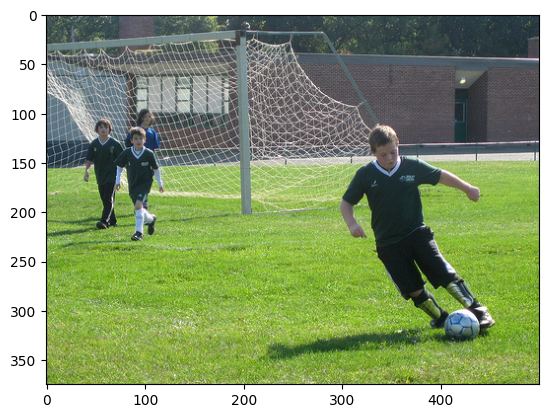

In [59]:
model = load_model('./model2/model_0.h5')
photo = train_features["2913965136_2d00136697.jpg"]
img = Image.open("/content/flickr8k/Images/2913965136_2d00136697.jpg")
description = decoder(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)




<START> a man in a red shirt is playing tennis <END>


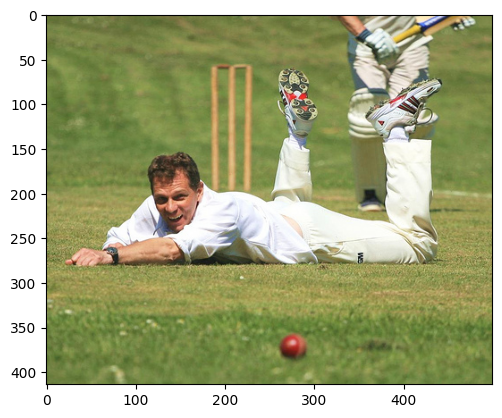

In [74]:
model = load_model('./model2/model_0.h5')
photo = train_features["2521938720_911ac092f7.jpg"]
img = Image.open("/content/flickr8k/Images/2521938720_911ac092f7.jpg")
description = decoder(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)




start a black dog is running through the grass end


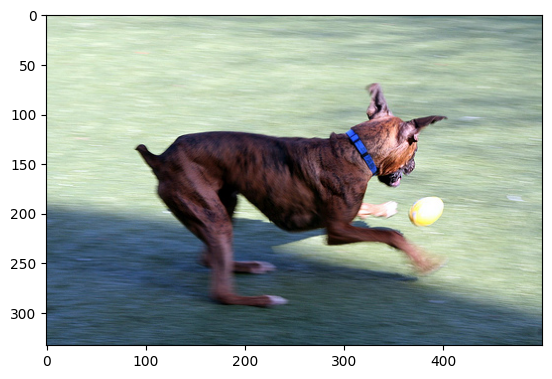

In [195]:
model = load_model('./model2/model_0.h5')
photo = val_features["422756764_e7eaac76bf.jpg"]
img = Image.open("/content/flickr8k/Images/422756764_e7eaac76bf.jpg")
description = decoder(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)




<START> a man in a red jacket is riding a bike <END>


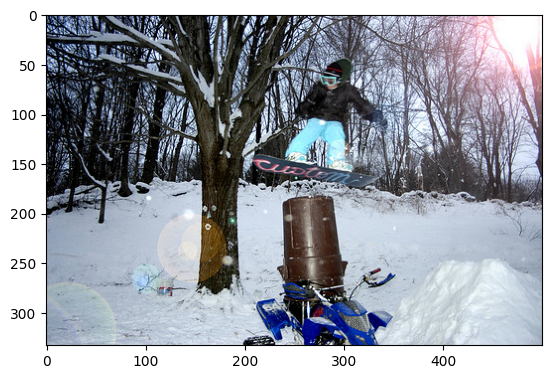

In [81]:
model = load_model('./model2/model_0.h5')
photo = train_features["3328397409_092de2bd32.jpg"]
img = Image.open("/content/flickr8k/Images/3328397409_092de2bd32.jpg")
description = decoder(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)




start a football player is playing in the air end


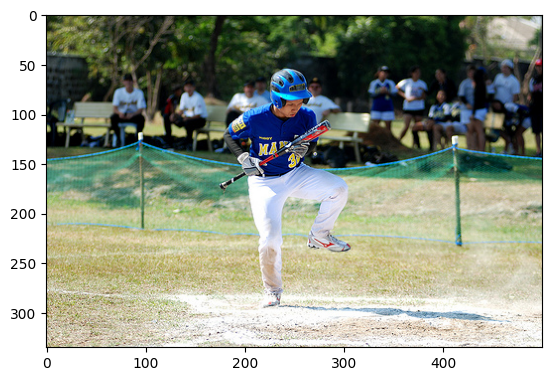

In [210]:
model = load_model('./model2/model_0.h5')
photo = train_features["3524914023_4e96edb09f.jpg"]
img = Image.open("/content/flickr8k/Images/3524914023_4e96edb09f.jpg")
description = decoder(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)